### importing libaries


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Flatten

In [39]:
data = pd.read_csv('Reliance.csv')
data.head()


,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-11-18,463.799988,465.649994,454.975006,456.000000,436.671021,5142766.0
1,2015-11-19,459.450012,469.350006,458.625000,467.375000,447.563873,5569752.0
2,2015-11-20,467.000000,476.399994,462.774994,473.424988,453.357422,5167930.0
3,2015-11-23,475.000000,478.950012,473.100006,476.875000,456.661224,4800026.0
4,2015-11-24,476.500000,485.799988,475.524994,483.850006,463.340515,6768886.0


## Drop values any null values

In [40]:
data.dropna(axis = 0, inplace = True)

## Check shape of the data

In [41]:
del data['Adj Close']
data.shape

(1232, 6)

## Copy dataset into new dataframe for plots

In [42]:
meta = data.copy()
meta['Date'] = pd.to_datetime(meta['Date'], format='%Y-%m-%d')
meta['Year'] = meta['Date'].dt.year
meta.head()

,Date,Open,High,Low,Close,Volume,Year
0,2015-11-18,463.799988,465.649994,454.975006,456.000000,5142766.0,2015
1,2015-11-19,459.450012,469.350006,458.625000,467.375000,5569752.0,2015
2,2015-11-20,467.000000,476.399994,462.774994,473.424988,5167930.0,2015
3,2015-11-23,475.000000,478.950012,473.100006,476.875000,4800026.0,2015
4,2015-11-24,476.500000,485.799988,475.524994,483.850006,6768886.0,2015


## Scatter plot of Close Price vs Year

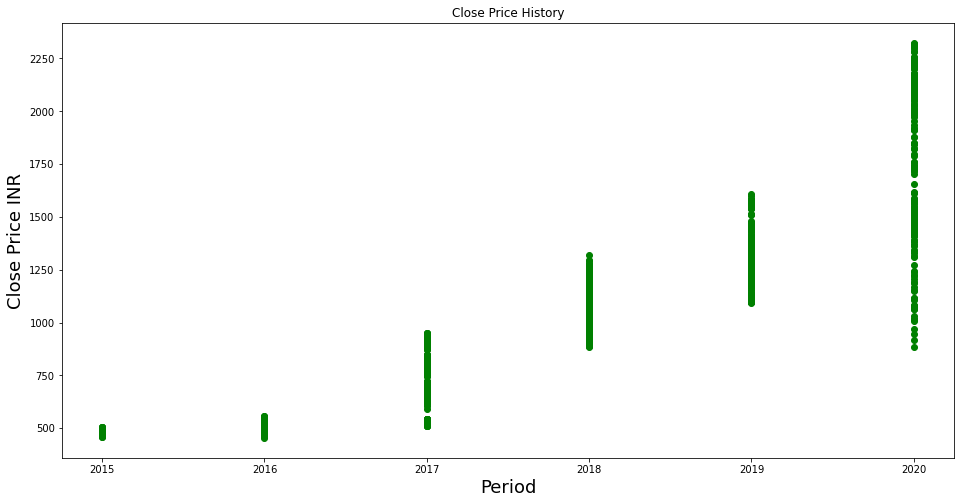

In [43]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.scatter(x = meta['Year'], y = meta['Close'], color = 'green')
plt.xlabel('Period', fontsize=18)
plt.ylabel('Close Price INR', fontsize=18)
plt.show()

## Line plot of Close Price vs Year

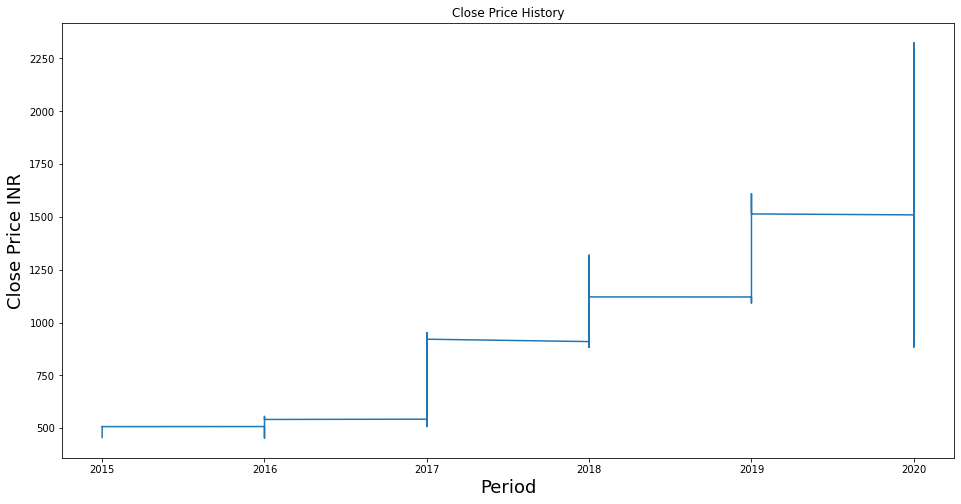

In [44]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(meta['Year'],meta['Close'])
plt.xlabel('Period', fontsize=18)
plt.ylabel('Close Price INR', fontsize=18)
plt.show()

## Distribution of Close Price on day basis

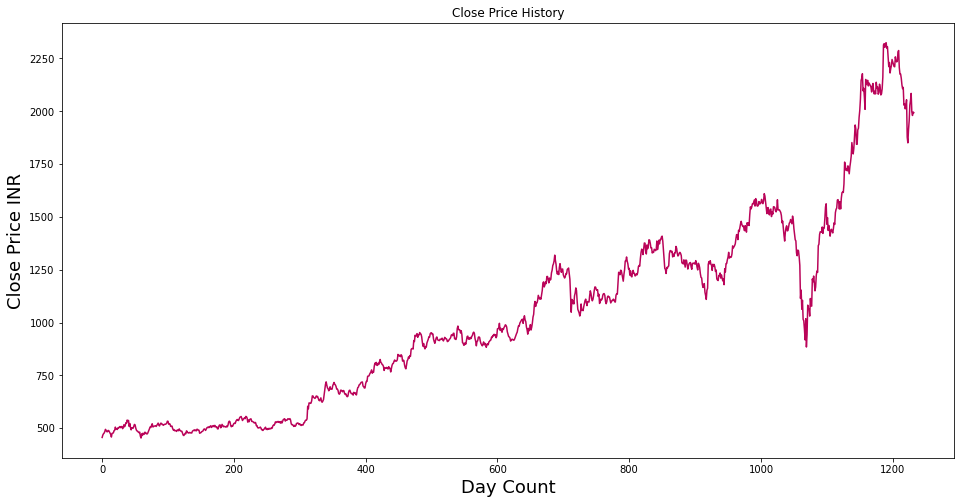

In [45]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(meta['Close'], color = '#ba0459')
plt.xlabel('Day Count', fontsize=18)
plt.ylabel('Close Price INR', fontsize=18)
plt.show()

## Scatter plot of Volume Traded vs Year

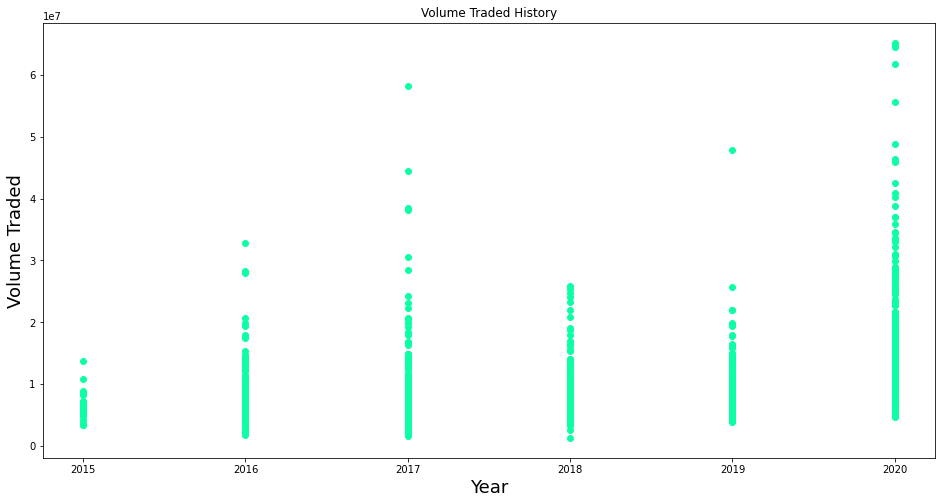

In [46]:
plt.figure(figsize=(16,8))
plt.title('Volume Traded History')
plt.scatter(x = meta['Year'], y = meta['Volume'], color = '#0dffa6')
plt.xlabel('Year', fontsize=18)
plt.ylabel('Volume Traded', fontsize=18)
plt.show()

## Distribution of Volume Traded on day basis

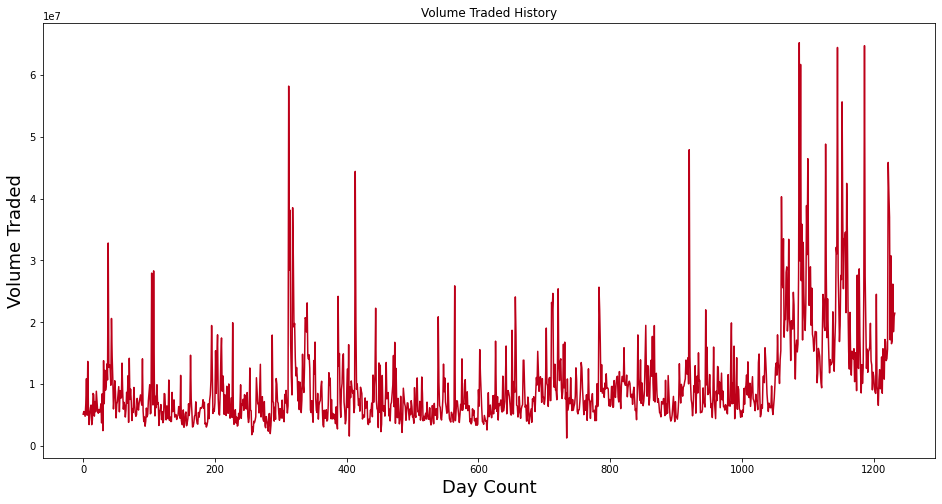

In [47]:
plt.figure(figsize=(16,8))
plt.title('Volume Traded History')
plt.plot(meta['Volume'], color = '#bd0019')
plt.xlabel('Day Count', fontsize=18)
plt.ylabel('Volume Traded', fontsize=18)
plt.show()

## Reset index of original dataframe

In [48]:
data.set_index('Date', inplace = True)
data.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-11-18,463.799988,465.649994,454.975006,456.000000,5142766.0
2015-11-19,459.450012,469.350006,458.625000,467.375000,5569752.0
2015-11-20,467.000000,476.399994,462.774994,473.424988,5167930.0
2015-11-23,475.000000,478.950012,473.100006,476.875000,4800026.0
2015-11-24,476.500000,485.799988,475.524994,483.850006,6768886.0


## Scale and transform the target and features column using MinMaxScaler

In [57]:
scaler = MinMaxScaler()
X = data[['Open', 'Low', 'High', 'Volume']].copy()
y = data['Close'].copy()

X[['Open', 'Low', 'High', 'Volume']] = scaler.fit_transform(X)
y = scaler.fit_transform(y.values.reshape(-1, 1))

## Function to split dataset into Train and Test dataset

In [93]:
def load_data(X, seq_len, train_size=0.8):
    amount_of_features = X.shape[1]
    X_mat = X.values
    sequence_length = seq_len + 1
    datanew = []
    
    for index in range(len(X_mat) - sequence_length):
        datanew.append(X_mat[index: index + sequence_length])
    
    datanew = np.array(datanew)
    train_split = int(round(train_size * datanew.shape[0]))
    train_data = datanew[:train_split, :]
    
    X_train = train_data[:, :-1]
    y_train = train_data[:, -1][:,-1]
    
    X_test = datanew[train_split:, :-1] 
    y_test = datanew[train_split:, -1][:,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return X_train, y_train, X_test, y_test

## Initializing the above function with a lookback window of 22

In [95]:
window = 22
X['close'] = y
X_train, y_train, X_test, y_test = load_data(X, window)
print(X_train.shape) 
print(y_train.shape) 
print(X_test.shape) 
print(y_test.shape)

(967, 22, 5)
(967,)
(242, 22, 5)
(242,)


## Building our LSTM model to make predictions

In [96]:
model = Sequential()
model.add(LSTM(128, input_shape= (window, 5), return_sequences = True))
model.add(Dropout(0.2))

model.add(LSTM(128, input_shape = (window, 5), return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(32))

model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, batch_size=1, validation_split = 0.1, epochs = 4)

Epoch 1/4
870/870 [==============================] - 22s 19ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 2/4
870/870 [==============================] - 16s 19ms/step - loss: 9.1360e-04 - val_loss: 9.5988e-04
Epoch 3/4
870/870 [==============================] - 16s 19ms/step - loss: 8.0325e-04 - val_loss: 0.0036
Epoch 4/4
870/870 [==============================] - 16s 19ms/step - loss: 7.3517e-04 - val_loss: 0.0016


## Check RMSE of Train and Test dataset

In [97]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)

trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([y_train])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([y_test])

trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))

testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

8/8 [==============================] - 0s 20ms/step
Train Score: 45.92 RMSE
Test Score: 176.20 RMSE


In [98]:
plot_predicted = testPredict.copy()
plot_predicted = plot_predicted.reshape(242, 1)
plot_actual = testY.copy()
plot_actual = plot_actual.reshape(242, 1)

plot_predicted_train = trainPredict.copy()
plot_predicted_train = plot_predicted_train.reshape(967, 1)
plot_actual_train = trainY.copy()
plot_actual_train = plot_actual_train.reshape(967, 1)

## Predictions on Train dataset

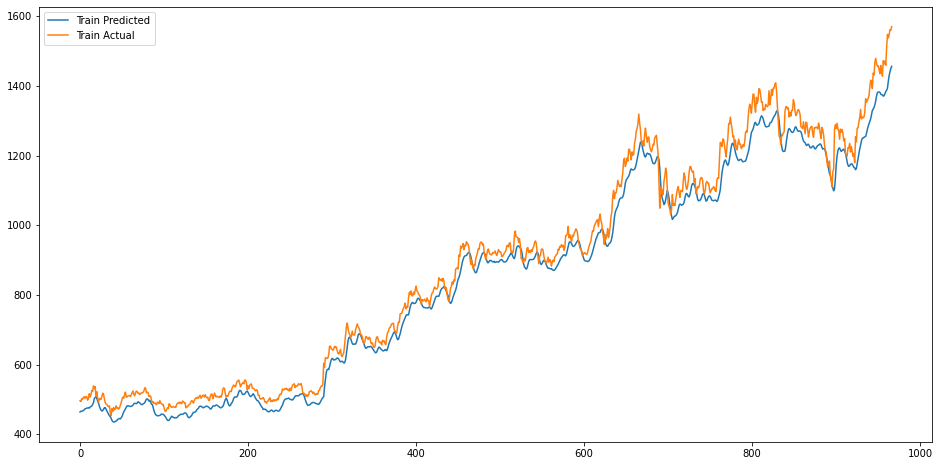

In [99]:
plt.figure(figsize = (16,8))
plt.plot(pd.DataFrame(plot_predicted_train), label='Train Predicted')
plt.plot(pd.DataFrame(plot_actual_train), label='Train Actual')
plt.legend(loc='best')
plt.show()

## Predictions on Test dataset

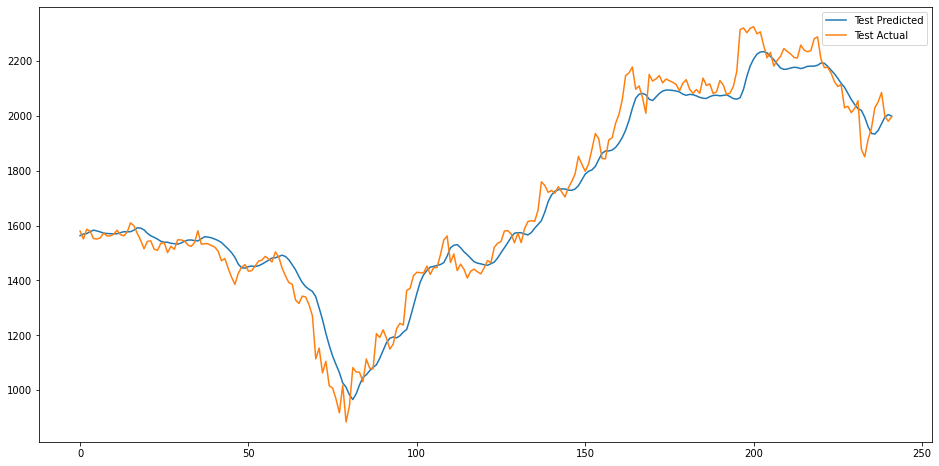

In [23]:
plt.figure(figsize = (16,8))
plt.plot(pd.DataFrame(plot_predicted), label='Test Predicted')
plt.plot(pd.DataFrame(plot_actual), label='Test Actual')
plt.legend(loc='best')
plt.show()